In [1]:
import pandas as pd
import numpy as np
import os
import sqlalchemy

from collections import Counter
import plotly.express as pe
from dotenv import load_dotenv
import plotly.io as pio
pio.renderers.default='notebook'

from datetime import date
import copy

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

In [3]:
from dython import nominal

In [4]:
from class_lib.feature_generator import *
from class_lib.segments_preparer import *
from class_lib.graph_lib import *
from class_lib.featureprocessor import *
from class_lib.feature_minorizer import *
from class_lib.FeatureSaver import FeatureSaver
from class_lib.saver import *
from class_lib.extra_feature_gen import ExtraFeatureGenerator

In [5]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import IsolationForest

In [6]:
# Cramers V for two categorical features
def cramers_v1(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# more good looking representative than Cramers V without symmetry
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

# Eta-function for the question "Given a continuous number, how well can you know to which category it belongs to?" 
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

-----------

## Timeline preparation

In [7]:
load_dotenv('.env')

host = os.getenv('EVENTS_DB_HOST')
db = os.getenv('EVENTS_DB_NAME')
user = os.getenv('EVENTS_DB_USER')
password = os.getenv('EVENTS_DB_PASSWORD')
port = os.getenv('EVENTS_DB_PORT')
connection_str = 'postgresql://{0}:{1}@{2}:{3}/{4}'.format(user, password, host, port, db)

engine = sqlalchemy.create_engine(connection_str, execution_options={"stream_results":True})

In [11]:
ACCOUNT_ID = 11

In [12]:
query_sessions = f'''
    select *
    from data.customer_profile_sessions cps 

    left join(
    select id as beh_id,guest_id, customer_profile_id from data.customer_profile_behaviour cpb
    where cpb.account_id = {ACCOUNT_ID}
    ) cpb on cpb.beh_id = cps.customer_profile_behaviour_id


    where cps.account_id = {ACCOUNT_ID} and cps.garbage_session = False and cps.session_start >= '2023-01-01' and cps.session_start < '2023-02-01' 
'''

sessions = pd.read_sql_query(query_sessions, engine)

In [13]:
sessions

,id,s_id,account_id,customer_profile_behaviour_id,channel,utm_source,utm_medium,utm_campaign,utm_content,utm_term,...,garbage_session,s_ci,source_id,medium_id,campaign_id,source_medium_id,is_conversion,beh_id,guest_id,customer_profile_id
0,58524542,t-1675209460728-3ohm178eOq5ExhN3bzBgE,11,29949072,Organic Search,None,None,None,None,None,...,False,1,73103,212,19022,73371,None,29949072,vf-1670066103277-q_sBh4dYf2iwImt3CJzKJ,39314407
1,58524391,t-1675208756443-WMVPoO5-eD7sfpIGmCuDK,11,30986652,Social,meta,Facebook_Mobile_Feed,TOFU_Winter22_Prospecting_Europe_Excluded-LT,AW22-WinterSale-carousel-influencer,None,...,False,3,72965,213,867761,73310,None,30986652,vf-1674858189483-VaQEtP_mX6W_ZdW0j-CdN,40414310
2,58524389,t-1675208750642-gbYJ3CEJErcrhA6uQb7Md,11,31067384,Social,meta,Facebook_Marketplace,TOFU_Winter22_Prospecting_Europe_Excluded-LT,AW22-WinterSale-carousel-influencer,None,...,False,1,72965,268,867761,73631,None,31067384,vf-1675208750642-Zqy71AoPgXg7R5psvDytt,40499070
3,58524390,t-1675208528790-uzSV_1FDJr9BQfcPU6I2B,11,30974943,Social,IGShopping,Social,None,Facebook_UA,None,...,False,1,73177,255,19022,73451,None,30974943,vf-1674805433177-HbLaaVWCUl73CYCzxRsOw,40401910
4,58524388,t-1675208429645-yiJqFmrgIy8wilzfH8LL9,11,31067383,Direct,None,None,None,None,None,...,False,0,72945,210,19022,73197,None,31067383,vf-1675208429645-3oHE4BUsHmYuWz1Gje1hl,40499069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25144,55905580,t-1672531881824-fH5UpQ8CJIP_dbLikAJQA,11,30416211,Social,meta,Instagram_Stories,TOFU_Winter22_LAL&Prospecting_DE,AW22-WinterSale-video-bona - Copy,None,...,False,0,72965,240,703833,73311,None,30416211,vf-1672531881826-rbcnT682AX7xRGKzDPbgG,39811209
25145,55905579,t-1672531865786-yVnHfy8o1X71takk6duw6,11,30416210,Social,meta,Facebook_Mobile_Feed,TOFU_Winter22_LAL&Prospecting_BE-NE-ES-SW-DENM-SWISS,AW22-WinterSale-carousel - Copy,None,...,False,0,72965,213,703832,73310,None,30416210,vf-1672531865788-5yho3_Z_J-HtCzGsOFfdm,39811208
25146,55905583,t-1672531766891-YnBNRVaDPdroJxDq-ZiQw,11,30414732,Direct,None,None,None,None,None,...,False,2,72964,212,19022,73215,None,30414732,vf-1672525282958-ZyyFqQ9ZTS-VYOVEhKcGd,39809717
25147,55905582,t-1672531521644-oo5NpLoF2qhPhpYLr-JZZ,11,30414733,Direct,None,None,None,None,None,...,False,1,72964,212,19022,73215,None,30414733,vf-1672525290757-3KuP4uZVuxqP_DWduO6Ez,39809718


In [142]:
sessions = pd.read_pickle('anom_und_2022.pkl')

In [ ]:
sessions_features = pd.read_pickle('sessions_features_und2022.pkl')

In [ ]:
print(sessions.session_start.min())
print(sessions.session_start.max())

In [ ]:
sessions.columns.tolist()

In [ ]:
sessions_features.columns.tolist()

In [ ]:
print(len(sessions))
print(len(sessions_features))

In [ ]:
print(len(sessions.guest_id.unique()))
print(len(sessions_features.guest_id.unique()))

In [143]:
sessions = sessions[sessions['session_start'] >= '2022-10-01']

In [ ]:
from datetime import datetime
sessions['date_group'] = sessions.session_start.dt.strftime('%j').astype('int')
# datetime.now().timetuple().tm_yday  # returns 1 for January 1st

In [ ]:
sessions['date_group'] = sessions.session_start.dt.isocalendar().week
# sessions['date_group'] = sessions.session_start.dt.month

In [ ]:
week_max = sessions.date_group.unique().max()
week_min = sessions.date_group.unique().min()

In [ ]:
print(sessions.date_group.unique().min())
print(sessions.date_group.unique().max())

In [ ]:
print(sessions.id.nunique())
print(sessions.guest_id.nunique())

In [ ]:
sessions = sessions.sort_values(['guest_id', 'session_start'])

In [ ]:
sessions = sessions.groupby('guest_id').last().reset_index()

In [ ]:
sessions[sessions['id'].isin()]

In [ ]:
data = []

In [ ]:
for i in range(week_min, week_max + 1):
    data.append(sessions[sessions['date_group'] == i].reset_index(drop=True).fillna(0))
    

In [ ]:
data[1].head()

In [ ]:
# for i in range(1, 12):
#     data.append(sessions[(sessions['session_start'] >= '2022-{0}-01'.format(i)) & (sessions['session_start'] < '2022-{0}-01'.format(i + 1))].reset_index(drop=True))
    
# data.append(sessions[(sessions['session_start'] >= '2022-12-01'.format(i)) & (sessions['session_start'] < '2023-01-01'.format(i + 1))].reset_index(drop=True))

In [ ]:
sessions_float_features = ['actions_count','page_views_count', 'add_to_basket_count']

sessions_cat_features = ['browser_family', 'os_family', 'device_family',
                        'device_brand', 'device_model',  'device_type',
                        'ipcountry', 'language', 'referer',
                         'source_medium_id']

In [ ]:
data[0][sessions_cat_features + sessions_float_features].head()

-------

-----

In [173]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

print('Pandas version:', pd.__version__)
# Pandas version: 1.3.0

tips = sns.load_dataset("tips")

tips["total_bill_cut"] = pd.cut(tips["total_bill"],
                                np.arange(0, 55, 5),
                                include_lowest=True,
                                right=False)

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(tips["day"], tips["time"])
print(cramers_v(confusion_matrix.values))
# Out[2]: 0.9386619340722221

confusion_matrix = pd.crosstab(tips["total_bill_cut"], tips["time"])
print(cramers_v(confusion_matrix.values))
# Out[3]: 0.1649870749498837

Pandas version: 1.5.2
0.9386619340722221
0.1649870749498837


In [ ]:
data1 = []
for d in data:
    data1.append(d[sessions_cat_features + sessions_float_features])

In [174]:
data1[0].head()

,channel,ipcountry,browser_family,browser_version,os_family,os_version,device_family,device_brand,device_model,device_type,...,events_before_atb_referer_first,events_before_atb_referer_last,events_before_atb_interval_between_mean,events_before_atb_interval_between_sum,events_before_atb_interval_between_amin,events_before_atb_interval_between_amax,sessions_before_atb_interval_between_mean,sessions_before_atb_interval_between_sum,sessions_before_atb_interval_between_amin,sessions_before_atb_interval_between_amax
15693,Social,US,Facebook,None,iOS,15.6.1,iPhone,Apple,"iPhone13,4",mobile,...,http://m.facebook.com/,http://m.facebook.com/,3.361333,10.084,3.251,3.483,NaN,0.0,NaN,NaN
15692,Social,US,Facebook,385.0.0,Android,12,Samsung SM-N981U,Samsung,SM-N981U,mobile,...,https://lm.facebook.com/,https://lm.facebook.com/,3.023000,21.161,0.000,13.303,NaN,0.0,NaN,NaN
15691,Referral,US,Chrome Mobile iOS,105.0.5195,iOS,15.6,iPhone,Apple,iPhone,mobile,...,https://iwearundress.com/,https://iwearundress.com/,1.679000,3.358,0.000,3.358,NaN,0.0,NaN,NaN
15694,Social,US,Facebook,None,iOS,15.6.1,iPad,Apple,"iPad7,6",tablet,...,http://m.facebook.com/,http://m.facebook.com/,2.478333,7.435,0.000,3.950,NaN,0.0,NaN,NaN
15697,Social,US,Facebook,None,iOS,15.6.1,iPhone,Apple,"iPhone12,5",mobile,...,http://m.facebook.com/,http://m.facebook.com/,3.131333,18.788,0.000,4.122,NaN,0.0,NaN,NaN


In [175]:
l = len(data1[0].columns)
# l1 = len(sessions_cat_features)

In [ ]:
dfc = []
for i in data1:
    assc = nominal.associations(i, compute_only=True, nom_nom_assoc='cramer', num_num_assoc='pearson', nom_num_assoc='correlation_ratio', mark_columns=True)
    dfc.append(assc['corr'])

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:293: RuntimeWarning:

Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:293: RuntimeWarning:

Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:293: RuntimeWarning:

Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:293: RuntimeWarning:

Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:293: RuntimeWarning:

Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:293: Runt

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: RuntimeWarning:

Rounded V = 1.0000000000000002 to 1.0. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: RuntimeWarning:

Rounded V = 1.0000000000000002 to 1.0. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: RuntimeWarning:

Rounded V = 1.0000000000000002 to 1.0. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: RuntimeWarning:

Rounded V = 1.0000000000000002 to 1.0. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: RuntimeWarning:

Rounded V = 1.0000000000000002 to 1.0. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: Runt

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: RuntimeWarning:

Rounded V = 1.0000000000000002 to 1.0. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: RuntimeWarning:

Rounded V = 1.0000000000000002 to 1.0. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: RuntimeWarning:

Rounded V = 1.0000000000000002 to 1.0. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: RuntimeWarning:

Rounded V = 1.0000000000000002 to 1.0. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: RuntimeWarning:

Rounded V = 1.0000000000000002 to 1.0. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: Runt

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:164: RuntimeWarning:

Rounded V = 1.0000000000000002 to 1.0. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:293: RuntimeWarning:

Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:293: RuntimeWarning:

Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:293: RuntimeWarning:

Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.

/home/ubuntu/.local/lib/python3.8/site-packages/dython/nominal.py:293: RuntimeWarning:

Rounded eta = 1.0000000000000002 to 1. This is probably due to floating point precision issues.



In [228]:
dfc[0]

,channel (nom),ipcountry (nom),browser_family (nom),browser_version (nom),os_family (nom),os_version (nom),device_family (nom),device_brand (nom),device_model (nom),device_type (nom),...,events_before_atb_referer_first (nom),events_before_atb_referer_last (nom),events_before_atb_interval_between_mean (con),events_before_atb_interval_between_sum (con),events_before_atb_interval_between_amin (con),events_before_atb_interval_between_amax (con),sessions_before_atb_interval_between_mean (con),sessions_before_atb_interval_between_sum (con),sessions_before_atb_interval_between_amin (con),sessions_before_atb_interval_between_amax (con)
channel (nom),1.000000,0.313126,0.598173,0.533049,0.297633,0.219040,0.000000,0.237838,0.000000,0.192028,...,0.764503,0.550316,0.473415,0.480501,0.479077,0.482910,0.484363,0.484363,0.484363,0.484363
ipcountry (nom),0.313126,1.000000,0.303538,0.268873,0.346950,0.286495,0.196004,0.487693,0.091777,0.159941,...,0.395712,0.254479,0.568783,0.238682,0.145003,0.238676,0.202614,0.202614,0.202614,0.202614
browser_family (nom),0.598173,0.303538,1.000000,0.840101,0.744933,0.383548,0.304172,0.403117,0.190432,0.656618,...,0.582920,0.415553,0.259187,0.073323,0.669847,0.091705,0.118171,0.118171,0.118171,0.118171
browser_version (nom),0.533049,0.268873,0.840101,1.000000,0.731916,0.402671,0.574074,0.552981,0.416109,0.362275,...,0.520913,0.345237,0.580754,0.182266,0.559601,0.191268,0.170051,0.170051,0.170051,0.170051
os_family (nom),0.297633,0.346950,0.744933,0.731916,1.000000,0.791011,0.712667,0.676679,0.535576,0.686227,...,0.484470,0.230219,0.256530,0.080854,0.698263,0.091274,0.090597,0.090597,0.090597,0.090597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
events_before_atb_interval_between_amax (con),0.482910,0.238676,0.091705,0.191268,0.091274,0.149729,0.102322,0.091941,0.478343,0.030401,...,0.201354,0.998921,0.817447,0.987663,0.019520,1.000000,0.988237,0.988237,0.988237,0.988237
sessions_before_atb_interval_between_mean (con),0.484363,0.202614,0.118171,0.170051,0.090597,0.156719,0.092802,0.086212,0.484396,0.035814,...,0.177288,1.000000,0.733052,0.971973,-0.021861,0.988237,1.000000,1.000000,1.000000,1.000000
sessions_before_atb_interval_between_sum (con),0.484363,0.202614,0.118171,0.170051,0.090597,0.156719,0.092802,0.086212,0.484396,0.035814,...,0.177288,1.000000,0.733052,0.971973,-0.021861,0.988237,1.000000,1.000000,1.000000,1.000000
sessions_before_atb_interval_between_amin (con),0.484363,0.202614,0.118171,0.170051,0.090597,0.156719,0.092802,0.086212,0.484396,0.035814,...,0.177288,1.000000,0.733052,0.971973,-0.021861,0.988237,1.000000,1.000000,1.000000,1.000000


In [229]:
# nominal.associations(data1[0].iloc[:, :94], compute_only=True, nom_nom_assoc='cramer', num_num_assoc='pearson', nom_num_assoc='correlation_ratio', mark_columns=True)['corr']

In [277]:
len(dfc[0].columns.tolist())

94

In [278]:
# l = len(df.columns)
# results = np.zeros((l,l))
# for i, ac in enumerate(df):
#     for j, bc in enumerate(df):
#            results[j,i] = func(ac,bc)
# results = DataFrame(results,index=df.columns,columns=df.columns)

In [279]:
def create_lofl(x, y, n=[]):
    lofl = []
    for i in range(y):
        ofl = []
        for j in range(x):
            ofl.append(n)
        lofl.append(ofl)
    return lofl

In [280]:
dum_list = create_lofl(l, l, [0])

In [281]:
# dum_list = [[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]],
#  [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]]

In [282]:
dum_list[1][1]

[0]

In [283]:
l

94

In [284]:
l = len(dfc[0].columns)
lists = copy.deepcopy(dum_list)
l

94

In [285]:
# lists[0][0] = lists[0][0] + [1]

In [286]:
dfc[0].iloc[0]

channel (nom)                                      1.000000
ipcountry (nom)                                    0.313126
browser_family (nom)                               0.598173
browser_version (nom)                              0.533049
os_family (nom)                                    0.297633
                                                     ...   
events_before_atb_interval_between_amax (con)      0.482910
sessions_before_atb_interval_between_mean (con)    0.484363
sessions_before_atb_interval_between_sum (con)     0.484363
sessions_before_atb_interval_between_amin (con)    0.484363
sessions_before_atb_interval_between_amax (con)    0.484363
Name: channel (nom), Length: 94, dtype: float64

In [287]:
n=0
for d in dfc:
    li = d.values.tolist()
#     print(li[1][0])
    for i in range(0, l):

        for j in range(0, l):
#             print(li[i][j])
            lists[i][j] = lists[i][j] + [li[i][j]]

In [288]:
for i in range(l):
        for j in range(l):
            lists[i][j] = lists[i][j][1:]

In [289]:
qlists = copy.deepcopy(lists)

In [290]:
lists[0]

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,

In [291]:
len(qlists[0][1])

339

In [292]:
q1 = 0
q9 = 0
for m in range(0, l):
        for b in range(0, l):
            q1 = np.quantile(qlists[m][b], .01)
            q9 = np.quantile(qlists[m][b], .99)
            qlists[m][b] = [q1, q9]

In [293]:
qlists

[[[1.0, 1.0],
  [0.0, 0.8200954374881035],
  [0.028091214775618996, 0.7430216662656307],
  [0.0, 0.7409083484432754],
  [0.0, 0.5810890598811537],
  [0.0, 0.6415500790479896],
  [0.0, 0.5714235348225728],
  [0.0, 0.5290017987929466],
  [0.0, 0.5162160371728396],
  [0.0, 0.6248164894287359],
  [0.0, 0.8841035671857674],
  [0.0, 0.727574792973063],
  [0.07593062613680719, 0.5901480545579739],
  [0.06478630933318152, 0.7345917319729017],
  [0.3251022437647858, 0.923874738257667],
  [0.0, 0.576773328898348],
  [0.0, 0.0],
  [0.06644896033217117, 0.8207566437448085],
  [0.07604926460025306, 0.9999965839096201],
  [0.0, 0.5470008187828369],
  [0.009636853187114863, 0.7440263598781919],
  [0.028091214775618996, 0.7430216662656307],
  [0.0, 0.0],
  [0.028091214775618996, 0.7430216662656307],
  [0.028091214775618996, 0.7430216662656307],
  [0.0, 0.5810890598811537],
  [0.0, 0.0],
  [0.0, 0.5810890598811537],
  [0.0, 0.5810890598811537],
  [0.0, 0.5714235348225728],
  [0.0, 0.0],
  [0.0, 0.57142

In [294]:
anlist = copy.deepcopy(dum_list)
listsc = copy.deepcopy(lists)
qlistc = copy.deepcopy(qlists)

In [295]:
for i in range(l):
        for j in range(l):
#             print(qlistc[i][j][0])
            it = 0
            for k in listsc[i][j]:
                it += 1
                if ((k < qlistc[i][j][0]) | (k > qlistc[i][j][1])):
                    anlist[i][j] = anlist[i][j] + [it] 
#                 anlist[i][j] = next((index + 1 for index, item in enumerate(listsc[i][j]) if ((item < qlistc[i][j][0]) | (item > qlistc[i][j][1]))), None)

In [296]:
anlist

[[[0, 238],
  [0, 326],
  [0, 238, 285, 302, 339],
  [0, 306],
  [0, 265, 333],
  [0, 287, 326],
  [0, 339],
  [0],
  [0, 339],
  [0, 247, 339],
  [0],
  [0, 326],
  [0, 233, 238, 273],
  [0, 238, 319, 326],
  [0, 238],
  [0, 228, 268],
  [0],
  [0, 238, 325],
  [0, 237, 238, 277, 307, 327],
  [0, 268],
  [0, 238, 291],
  [0, 238, 285, 302, 339],
  [0, 282],
  [0, 238, 285, 302, 339],
  [0, 238, 285, 302, 339],
  [0, 265, 333],
  [0, 282],
  [0, 265, 333],
  [0, 265, 333],
  [0, 339],
  [0, 282],
  [0, 339],
  [0, 339],
  [0],
  [0, 282],
  [0],
  [0],
  [0, 339],
  [0, 282],
  [0, 339],
  [0, 339],
  [0, 238],
  [0, 280],
  [0, 238, 323, 339],
  [0, 238],
  [0, 247, 339],
  [0, 282],
  [0, 247, 339],
  [0, 247, 339],
  [0, 256],
  [0],
  [0],
  [0, 254, 293],
  [0, 326],
  [0, 238],
  [0, 326],
  [0, 326],
  [0, 238, 326],
  [0, 238, 311, 326, 330],
  [0, 238, 260, 326],
  [0, 238, 314, 326, 330],
  [0, 238, 288, 292, 326],
  [0, 238, 292, 318, 326],
  [0, 238, 288, 292, 326],
  [0, 2

In [297]:
dfc[21]

,channel (nom),ipcountry (nom),browser_family (nom),browser_version (nom),os_family (nom),os_version (nom),device_family (nom),device_brand (nom),device_model (nom),device_type (nom),...,events_before_atb_referer_first (nom),events_before_atb_referer_last (nom),events_before_atb_interval_between_mean (con),events_before_atb_interval_between_sum (con),events_before_atb_interval_between_amin (con),events_before_atb_interval_between_amax (con),sessions_before_atb_interval_between_mean (con),sessions_before_atb_interval_between_sum (con),sessions_before_atb_interval_between_amin (con),sessions_before_atb_interval_between_amax (con)
channel (nom),1.000000,0.375783,0.569908,0.541477,0.286226,0.163932,0.216926,0.081506,0.128790,0.237203,...,0.735181,0.410062,0.087559,0.126110,0.154470,0.125197,0.145891,0.127548,0.146870,0.144875
ipcountry (nom),0.375783,1.000000,0.218912,0.245941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047039,0.000000,0.240782,0.256510,0.275336,0.272048,0.358150,0.314959,0.361001,0.355288
browser_family (nom),0.569908,0.218912,1.000000,0.945313,0.752790,0.456643,0.457095,0.183086,0.455801,0.686903,...,0.810975,0.452047,0.129794,0.189018,0.167647,0.185461,0.191294,0.176870,0.191806,0.190712
browser_version (nom),0.541477,0.245941,0.945313,1.000000,0.844741,0.374177,0.470351,0.403303,0.412942,0.689278,...,0.532862,0.093409,0.301568,0.364385,0.418456,0.336491,0.286577,0.279446,0.287255,0.285927
os_family (nom),0.286226,0.000000,0.752790,0.844741,1.000000,0.919435,0.873434,0.684888,0.717958,0.699893,...,0.854789,0.253983,0.190419,0.239135,0.139324,0.215162,0.113754,0.155320,0.110087,0.117272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
events_before_atb_interval_between_amax (con),0.125197,0.272048,0.185461,0.336491,0.215162,0.353922,0.833114,0.299444,0.847389,0.049250,...,0.294559,0.460526,0.828995,0.970628,-0.094144,1.000000,0.665017,0.634614,0.664475,0.665161
sessions_before_atb_interval_between_mean (con),0.145891,0.358150,0.191294,0.286577,0.113754,0.240072,0.565713,0.133494,0.610852,0.042881,...,0.318650,0.500047,0.135957,0.705452,-0.081904,0.665017,1.000000,0.947569,0.999700,0.999714
sessions_before_atb_interval_between_sum (con),0.127548,0.314959,0.176870,0.279446,0.155320,0.266386,0.756357,0.196199,0.778138,0.043028,...,0.375856,0.726659,0.127107,0.744919,-0.082184,0.634614,0.947569,1.000000,0.939458,0.954944
sessions_before_atb_interval_between_amin (con),0.146870,0.361001,0.191806,0.287255,0.110087,0.238564,0.551605,0.129435,0.598839,0.042685,...,0.313179,0.482350,0.136049,0.699381,-0.081529,0.664475,0.999700,0.939458,1.000000,0.998828


In [298]:
for i in range(l):
        for j in range(l):
            anlist[i][j] = anlist[i][j][1:]

In [299]:
figx = pd.DataFrame(lists[0][5], columns=['cor_coef'], index=range(week_min ,week_max + 1))
figx['mean'] = figx.cor_coef.mean()
figx['q01'] = np.quantile(figx.cor_coef, .01)
figx['q99'] = np.quantile(figx.cor_coef, .99)

<AxesSubplot: >

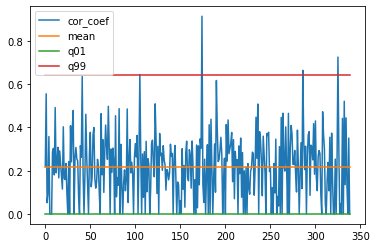

In [300]:
figx.plot()

In [301]:
figx

,cor_coef,mean,q01,q99
0,0.219040,0.219041,0.0,0.64155
1,0.555868,0.219041,0.0,0.64155
2,0.051722,0.219041,0.0,0.64155
3,0.091647,0.219041,0.0,0.64155
4,0.357872,0.219041,0.0,0.64155
...,...,...,...,...
334,0.444453,0.219041,0.0,0.64155
335,0.130735,0.219041,0.0,0.64155
336,0.000000,0.219041,0.0,0.64155
337,0.350839,0.219041,0.0,0.64155


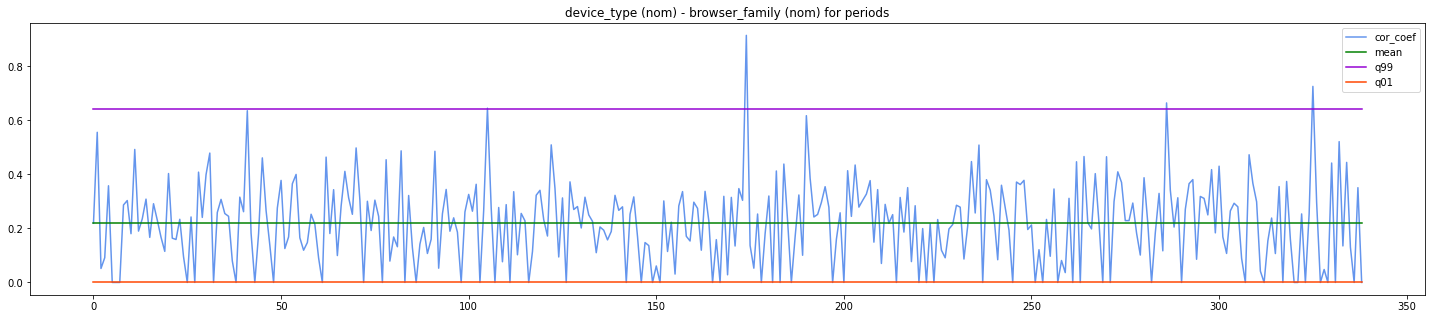

In [302]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
ax1 = figx.plot(use_index=True, y='cor_coef',  kind='line', ax=axes, figsize=(25, 5), title='device_type (nom) - browser_family (nom) for periods', color='cornflowerblue')
ax2 = figx.plot(y='mean', ax=axes, color='green')
ax3 = figx.plot(y='q99', ax=axes, color='darkviolet')
ax4 = figx.plot(y='q01', ax=axes, color='orangered')
# ax5 = figx.plot(use_index=True, y='conv',  ax=axes, color='lightblue', linewidth=5, linestyle='--')
# ax1.set_xlabel('week')

In [303]:
lists[12][12]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [304]:
qlists[12][12]

[1.0, 1.0]

In [305]:
dfanlist = pd.DataFrame(anlist,index=dfc[0].columns,columns=dfc[0].columns)
dfanlist

,channel (nom),ipcountry (nom),browser_family (nom),browser_version (nom),os_family (nom),os_version (nom),device_family (nom),device_brand (nom),device_model (nom),device_type (nom),...,events_before_atb_referer_first (nom),events_before_atb_referer_last (nom),events_before_atb_interval_between_mean (con),events_before_atb_interval_between_sum (con),events_before_atb_interval_between_amin (con),events_before_atb_interval_between_amax (con),sessions_before_atb_interval_between_mean (con),sessions_before_atb_interval_between_sum (con),sessions_before_atb_interval_between_amin (con),sessions_before_atb_interval_between_amax (con)
channel (nom),[238],[326],"[238, 285, 302, 339]",[306],"[265, 333]","[287, 326]",[339],[],[339],"[247, 339]",...,[238],[326],[238],"[238, 295]","[238, 289, 338]","[238, 271, 295]","[238, 266, 333]","[238, 266]","[238, 266, 333]","[238, 266]"
ipcountry (nom),[326],[],"[250, 260]","[246, 250]",[284],"[274, 326]",[291],"[246, 291]",[],[],...,[],[326],"[237, 266]","[238, 286, 293]","[284, 295]","[280, 293]","[238, 280]","[238, 280]",[238],"[238, 280]"
browser_family (nom),"[238, 285, 302, 339]","[250, 260]",[],"[262, 286]","[227, 238, 326]","[262, 274, 323, 326, 337]","[248, 299, 323, 329, 333]","[238, 323, 325, 339]",[248],"[259, 270]",...,"[238, 260]","[227, 238]","[238, 246, 247, 255, 260]","[247, 260, 308]","[284, 289]","[247, 255, 260, 294, 308]","[238, 294]","[238, 308]","[238, 294]","[238, 294]"
browser_version (nom),[306],"[246, 250]","[262, 286]",[],"[264, 278, 337, 339]","[238, 272, 276, 281]","[245, 281]","[227, 238, 240, 274, 278]",[241],"[262, 339]",...,"[277, 309, 323]","[238, 271, 318]","[241, 246, 247, 255]","[246, 247, 268, 326]","[295, 299]","[246, 247, 255, 326]","[238, 246, 326]","[238, 246, 326]","[238, 326]","[238, 246, 326]"
os_family (nom),"[265, 333]",[284],"[227, 238, 326]","[264, 278, 337, 339]",[],[318],"[238, 248]","[236, 282]","[229, 325]","[238, 259, 266, 269]",...,"[229, 255, 278, 323]","[238, 323]",[238],"[246, 247, 278, 287]","[259, 284, 291, 314, 338]","[238, 246, 278, 287]","[238, 246, 278, 333]","[238, 246, 247, 278]","[238, 246, 333]","[238, 246, 247, 278]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
events_before_atb_interval_between_amax (con),"[238, 271, 295]","[280, 293]","[247, 255, 260, 294, 308]","[246, 247, 255, 326]","[238, 246, 278, 287]",[326],"[270, 290, 327]","[234, 268]","[280, 290]","[238, 246, 259, 330]",...,"[279, 280, 294]","[236, 326]",[265],"[236, 238, 246, 279, 307]","[229, 238, 275, 318]",[],"[238, 246]","[238, 246]","[238, 246]","[234, 238, 289, 295]"
sessions_before_atb_interval_between_mean (con),"[238, 266, 333]","[238, 280]","[238, 294]","[238, 246, 326]","[238, 246, 278, 333]","[238, 294, 326]",[238],"[234, 238]","[238, 275]",[246],...,"[234, 238, 280]","[238, 326]","[227, 255, 307]","[238, 246]","[275, 283]","[238, 246]",[238],[238],[238],[238]
sessions_before_atb_interval_between_sum (con),"[238, 266]","[238, 280]","[238, 308]","[238, 246, 326]","[238, 246, 247, 278]","[238, 326]","[238, 270, 290]",[238],"[238, 275, 290]",[246],...,"[238, 280]","[238, 326]",[227],"[238, 310, 332, 335]","[275, 283]","[238, 246]",[238],[238],[238],[238]
sessions_before_atb_interval_between_amin (con),"[238, 266, 333]",[238],"[238, 294]","[238, 326]","[238, 246, 333]","[238, 326]",[238],"[234, 238]",[238],"[246, 334]",...,"[238, 248, 280]","[238, 326]","[227, 255]","[238, 246]","[275, 283]","[238, 246]",[238],[238],[238],[238]


In [306]:
dfanlist.to_csv('feat_coran_und99_10_12_2022_last_month.csv')

In [262]:
k = []
for i in range(0, l):
    for j in range(0, l):
        k += anlist[i][j]

[238]
[105, 175, 179, 326]
[61, 105, 106, 179, 238, 285, 302, 339]
[12, 17, 61, 306]
[2, 66, 265, 333]
[106, 175, 287, 326]
[191, 192, 205, 339]
[144, 191, 195, 205]
[191, 192, 205, 339]
[212, 219, 247, 339]
[105, 175, 179, 191]
[105, 175, 191, 326]
[12, 145, 191, 210, 221, 233, 238, 273]
[9, 105, 175, 179, 191, 238, 319, 326]
[105, 114, 119, 175, 179, 183, 221, 238]
[183, 192, 228, 268]
[]
[105, 106, 129, 147, 158, 178, 238, 325]
[105, 190, 205, 237, 238, 277, 307, 327]
[115, 191, 192, 268]
[105, 175, 178, 179, 180, 190, 238, 291]
[61, 105, 106, 179, 238, 285, 302, 339]
[48, 93, 282]
[61, 105, 106, 179, 238, 285, 302, 339]
[61, 105, 106, 179, 238, 285, 302, 339]
[2, 66, 265, 333]
[48, 93, 282]
[2, 66, 265, 333]
[2, 66, 265, 333]
[191, 192, 205, 339]
[48, 93, 282]
[191, 192, 205, 339]
[191, 192, 205, 339]
[144, 191, 195, 205]
[282]
[144, 191, 195, 205]
[144, 191, 195, 205]
[191, 192, 205, 339]
[48, 93, 282]
[191, 192, 205, 339]
[191, 192, 205, 339]
[105, 175, 179, 238]
[89, 97, 190, 28

[25, 107, 175, 191, 238, 280, 286, 338]
[92, 190, 191, 195]
[66, 191, 195, 287]
[18, 238, 248, 339]
[64, 175, 194, 199, 238, 290, 323, 326]
[34, 114, 170, 193, 238, 246, 265, 339]
[217, 238, 246, 248]
[115, 140, 220, 234, 239, 242, 287, 301]
[3, 16, 28, 115, 120, 165, 234, 268]
[13, 18, 66, 174, 240, 284, 299, 313]
[3, 16, 115, 120, 165, 212, 234, 268]
[88, 105, 120, 148, 175, 179, 234, 238]
[105, 120, 148, 162, 165, 175, 179, 238]
[88, 105, 120, 148, 175, 179, 234, 238]
[105, 120, 148, 162, 165, 175, 179, 238]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[]
[]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[282]
[28

[66, 72, 135, 191, 239, 268, 296, 324]
[66, 72, 191, 239, 253, 268, 296, 326]
[8, 66, 175, 238, 244, 293, 307, 326]
[105, 106, 178, 184, 224, 238, 247, 278]
[3, 89, 106, 174, 190, 221, 302, 303]
[21, 37, 50, 322]
[139, 180, 185, 199, 206, 238, 280, 339]
[46, 105, 151, 175, 179, 238, 324, 326]
[105, 179, 280, 291, 294, 298, 313, 318]
[105, 135, 175, 179, 201, 238, 288, 326]
[66, 105, 114, 175, 179, 203, 238, 326]
[2, 127, 175, 180, 191, 238, 296, 326]
[175, 178, 179, 180, 227, 238, 241, 298]
[58, 61, 145, 175, 179, 180, 193, 238]
[175, 179, 180, 227, 238, 283, 326, 339]
[57, 63, 69, 88, 178, 221, 262, 274]
[51, 56, 86, 88, 105, 175, 179, 184]
[48, 52, 66, 144, 190, 198, 238, 265]
[51, 56, 86, 88, 105, 175, 184, 274]
[51, 86, 102, 184, 226, 274, 278, 309]
[51, 86, 102, 184, 274, 277, 278, 309]
[51, 86, 102, 184, 226, 277, 278, 298]
[51, 86, 184, 226, 274, 278, 294, 309]
[31, 80, 105, 175, 179, 238, 318, 326]
[6, 175, 179, 180, 238, 259, 274, 326]
[2, 13, 26, 80, 165, 238, 263, 283]
[29, 

[105, 110, 122, 148, 175, 179, 192, 238]
[88, 105, 120, 148, 175, 179, 234, 238]
[282]
[88, 105, 120, 148, 175, 179, 234, 238]
[88, 105, 120, 148, 175, 179, 234, 238]
[105, 122, 148, 175, 179, 191, 192, 238]
[48, 93, 282]
[105, 122, 148, 175, 179, 191, 192, 238]
[105, 122, 148, 175, 179, 191, 192, 238]
[77, 78, 105, 175, 179, 180, 182, 238]
[120, 190, 191, 221, 281, 285, 312, 334]
[77, 78, 105, 175, 179, 180, 182, 238]
[105, 152, 175, 179, 182, 190, 238, 266]
[164, 196, 246, 334]
[48, 93, 282]
[164, 196, 246, 334]
[164, 196, 246, 334]
[12, 190, 258, 262]
[2, 7, 16, 18, 122, 190, 192, 255]
[12, 180, 190, 255]
[79, 108, 255, 265]
[105, 175, 179, 180, 193, 221, 238, 326]
[8, 190, 191, 297, 326]
[105, 175, 179, 180, 193, 221, 238, 326]
[105, 175, 179, 180, 192, 193, 238, 275]
[51, 56, 93, 106, 178, 284, 315, 320]
[51, 56, 106, 191, 224, 278, 309, 320]
[20, 53, 71, 85, 178, 253, 284, 298]
[51, 56, 106, 191, 229, 279, 315, 320]
[51, 86, 184, 226, 253, 277, 284, 298]
[8, 51, 94, 104, 117, 184

In [263]:
data_dates1 = []
data_dates2 = []
for d in data:
    data_dates1.append(d['last_session_start'].min())
    data_dates2.append(d['last_session_start'].max())

In [264]:
k1 = pd.DataFrame(k, columns=['period']).value_counts().reset_index().rename(columns={0: 'counts'})

In [265]:
k1['counts'] = k1['counts'] / 2
k1 = k1.sort_values('period')
k1['beg_date'] = data_dates1
k1['end_date'] = data_dates2
k1 = k1.sort_values('counts', ascending=False).reset_index(drop=True)

In [311]:
k1 = k1.sort_values('counts', ascending=False).reset_index(drop=True)

In [312]:
k1

,period,counts,beg_date,end_date
0,238,1624.0,2022-12-05 11:26:33.687,2022-12-05 11:38:53.572
1,175,1038.0,2022-11-17 19:47:49.382,2022-11-17 20:09:10.294
2,179,1036.0,2022-11-18 14:16:32.326,2022-11-18 14:22:25.680
3,105,869.0,2022-10-27 14:49:07.957,2022-10-27 15:03:27.917
4,326,735.0,2022-12-29 10:17:29.027,2022-12-29 10:25:42.382
...,...,...,...,...
334,251,6.0,2022-12-08 05:06:57.732,2022-12-08 11:16:34.344
335,53,6.0,2022-10-13 15:14:07.799,2022-10-13 18:59:00.905
336,91,5.0,2022-10-23 14:51:48.508,2022-10-23 18:31:23.824
337,142,5.0,2022-11-07 20:56:52.275,2022-11-08 08:35:47.873


In [313]:
k1.to_csv('period_counts_und99_10_12_2022.csv')

In [307]:
k1.sort_values('beg_date').reset_index(drop=True).to_csv('period_counts_und99_10_12_2022.csv')

In [314]:
k1[k1['beg_date'] >= '2022-12-01'].reset_index(drop=True).to_csv('period_counts_und99_10_12_2022_last_month.csv')

In [ ]:
data_dates1[0]

In [ ]:
data_dates2[0]

In [ ]:
lists[4][7]

In [ ]:
qlists[4][7]

------------

In [133]:
fe_mer = pd.read_pickle('features_merged_3m.pkl')

In [134]:
fe_mer.head()

,guest_id,sessions_before_atb_num_records,sessions_before_atb_browser_family_mf,sessions_before_atb_browser_family_weight_mf,sessions_before_atb_browser_family_first,sessions_before_atb_browser_family_last,sessions_before_atb_os_family_mf,sessions_before_atb_os_family_weight_mf,sessions_before_atb_os_family_first,sessions_before_atb_os_family_last,...,events_before_atb_referer_first,events_before_atb_referer_last,events_before_atb_interval_between_mean,events_before_atb_interval_between_sum,events_before_atb_interval_between_amin,events_before_atb_interval_between_amax,sessions_before_atb_interval_between_mean,sessions_before_atb_interval_between_sum,sessions_before_atb_interval_between_amin,sessions_before_atb_interval_between_amax
0,vf-1654368757191-JcllNqTfS13a933A_hmhh,124,Mobile Safari,1.0,Mobile Safari,Mobile Safari,iOS,1.0,iOS,iOS,...,https://www.google.com/,NaN,4929.009383,7871627.985,0.0,559510.927,63589.584203,7821518.857,-24.229,559512.577
1,vf-1664522323815-ZAqxxGutg7XlQT15VoEh6,55,Firefox,1.0,Firefox,Firefox,Windows,1.0,Windows,Windows,...,https://iwearundress.com/collections/aw22,https://iwearundress.com/collections,1095.874300,6363742.063,0.0,1114312.709,114479.173778,6181875.384,1820.097,1113561.503
2,vf-1653383105855-buf3RKdhbGJbexhSb9hTi,46,Chrome,1.0,Chrome,Chrome,Windows,1.0,Windows,Windows,...,NaN,https://iwearundress.com/,4298.392538,3636440.087,0.0,285133.951,79165.495911,3562447.316,1950.343,285275.172
3,vf-1669819959612-lyHr9PdvB8PaB95GemLC_,38,Mobile Safari,1.0,Mobile Safari,Mobile Safari,iOS,1.0,iOS,iOS,...,NaN,NaN,4940.120186,2662724.780,0.0,412769.375,71405.349784,2641997.942,1955.958,412768.829
4,vf-1670842316114-D9da6TJN8_iJtKmY2IXkV,32,Chrome,1.0,Chrome,Chrome,Mac OS X,1.0,Mac OS X,Mac OS X,...,NaN,NaN,1227.706211,1565325.419,0.0,416647.604,49196.903161,1525103.998,1809.000,416649.826


In [135]:
fe_mer.columns.tolist()

['guest_id',
 'sessions_before_atb_num_records',
 'sessions_before_atb_browser_family_mf',
 'sessions_before_atb_browser_family_weight_mf',
 'sessions_before_atb_browser_family_first',
 'sessions_before_atb_browser_family_last',
 'sessions_before_atb_os_family_mf',
 'sessions_before_atb_os_family_weight_mf',
 'sessions_before_atb_os_family_first',
 'sessions_before_atb_os_family_last',
 'sessions_before_atb_device_family_mf',
 'sessions_before_atb_device_family_weight_mf',
 'sessions_before_atb_device_family_first',
 'sessions_before_atb_device_family_last',
 'sessions_before_atb_device_brand_mf',
 'sessions_before_atb_device_brand_weight_mf',
 'sessions_before_atb_device_brand_first',
 'sessions_before_atb_device_brand_last',
 'sessions_before_atb_device_model_mf',
 'sessions_before_atb_device_model_weight_mf',
 'sessions_before_atb_device_model_first',
 'sessions_before_atb_device_model_last',
 'sessions_before_atb_channel_session_mf',
 'sessions_before_atb_channel_session_weight_mf'

In [136]:
fe_mer.guest_id.nunique()

35088

In [101]:
# query_sessions = f'''
#     select *
#     from data.customer_profile_sessions cps 

#     right join(
#     select id as beh_id,guest_id, customer_profile_id from data.customer_profile_behaviour cpb
#     where cpb.account_id = {ACCOUNT_ID}
#     ) cpb on cpb.beh_id = cps.customer_profile_behaviour_id


#     where cps.session_start >= '2022-10-01' and cps.session_start < '2023-01-01' and cps.account_id = 11 and cps.garbage_session = False
# '''

# newd = pd.read_sql_query(query_sessions, engine)

In [324]:
ACCOUNT_ID = 411

In [325]:
query_sessions = f'''
    select 
    id as beh_id,
    guest_id,
    last_session_id,
    session_start as last_session_start,
    session_end as last_session_end
    from data.customer_profile_behaviour cpb 

    left join(
    select id as ses_id, session_start, session_end from data.customer_profile_sessions cps
    where cps.account_id = {ACCOUNT_ID}
    ) cps on cpb.last_session_id = cps.ses_id


    where cpb.account_id = {ACCOUNT_ID} and cps.session_start >= '2022-10-01' and cps.session_start < '2023-01-01' 
'''

newd = pd.read_sql_query(query_sessions, engine)

In [326]:
newd

,beh_id,guest_id,last_session_id,last_session_start,last_session_end
0,30168096,vf-1671092127128-6IML5ADtrpsu_Du6ypVRD,55343644,2022-12-15 08:15:27.831,2022-12-15 08:15:27.959
1,30168168,vf-1671092390852-KVYjgDtUYsuqzHGTjt8XO,55343745,2022-12-15 08:19:49.243,2022-12-15 08:20:59.595
2,30156749,vf-1671015171701-kLZMsjc0AxtQ7XsUARo27,55325299,2022-12-14 10:52:52.066,2022-12-14 10:53:23.818
3,29881437,vf-1669832278005-DsXjeQiwihk-KFBcsZX1H,55463031,2022-12-21 20:44:58.053,2022-12-21 20:45:29.380
4,30240550,vf-1671655738560-C9hKlEGH6Eu-h8H02a4Az,55463024,2022-12-21 20:49:00.065,2022-12-21 20:49:00.625
...,...,...,...,...,...
48950,29985069,vf-1670203346034-i86UrkHlR4Ulo4bNXnSWT,55260928,2022-12-11 14:08:55.838,2022-12-11 14:21:27.882
48951,29985757,vf-1670209156885-WVsgKKon2C3-nzsIFwpB4,54895994,2022-12-05 02:59:17.598,2022-12-05 03:01:29.181
48952,29986058,vf-1670209602900-O__AQU-pOimDcCrWWeSrp,54896812,2022-12-05 03:06:43.760,2022-12-05 03:07:34.330
48953,29986391,vf-1670213246878-9wmTqZc02qQGZPRm62XU3,54898070,2022-12-05 04:00:17.150,2022-12-05 04:00:58.839


In [138]:
newd = newd.sort_values('last_session_start').reset_index(drop=True)
newd.head()

,beh_id,guest_id,last_session_id,last_session_start,last_session_end
0,27937040,vf-1664583072297-iBOmcssUmXg2owiHzhO5J,48172500,2022-10-01 00:11:27.855,2022-10-01 00:11:28.152
1,27937232,vf-1664583524654-sj_bqAfD2dpQWJ5Re_evw,48172829,2022-10-01 00:18:45.274,2022-10-01 00:18:54.958
2,27937233,vf-1664583958671-UtTQhaeL4ppNCcfNNzrPX,48172830,2022-10-01 00:26:00.750,2022-10-01 00:26:22.463
3,27937234,vf-1664584323412-74wVsGrWuxpmVF7heQrjN,48172831,2022-10-01 00:32:03.988,2022-10-01 00:32:07.801
4,27937235,vf-1664584378410-BvQuTSI2dO-BclDUvdmQj,48172832,2022-10-01 00:32:59.375,2022-10-01 00:33:07.002


In [139]:
newd.guest_id.nunique()

52181

In [140]:
newd1 = newd[['last_session_id', 'last_session_start']]

In [141]:
newd1

,last_session_id,last_session_start
0,48172500,2022-10-01 00:11:27.855
1,48172829,2022-10-01 00:18:45.274
2,48172830,2022-10-01 00:26:00.750
3,48172831,2022-10-01 00:32:03.988
4,48172832,2022-10-01 00:32:59.375
...,...,...
52176,55905411,2022-12-31 23:40:12.318
52177,55905412,2022-12-31 23:40:45.864
52178,55905413,2022-12-31 23:44:03.378
52179,55905414,2022-12-31 23:46:40.827


In [144]:
print(sessions.session_start.min())
print(sessions.session_start.max())
print(sessions.guest_id.nunique())
print(sessions.id.nunique())

2022-10-01 00:07:37.585000
2022-12-31 23:56:44.223000
53296
66089


In [145]:
sessions = sessions[sessions.id.isin(newd.last_session_id)]

In [146]:
print(sessions.id.nunique())

52083


In [147]:
sessions = sessions.merge(newd1, how='inner', left_on='id', right_on='last_session_id').drop('last_session_id', axis=1).merge(
fe_mer, how='inner', left_on='guest_id', right_on='guest_id')

In [148]:
sessions.columns.tolist()

['id',
 's_id',
 'account_id',
 'customer_profile_behaviour_id',
 'channel',
 'utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_content',
 'utm_term',
 'ip',
 'ipcountry',
 'browser_family',
 'browser_version',
 'os_family',
 'os_version',
 'device_family',
 'device_brand',
 'device_model',
 'device_type',
 'screen',
 'language',
 'session_start',
 'session_end',
 'created',
 'updated',
 'actions_count',
 'page_views_count',
 'referer',
 'add_to_basket_count',
 'garbage_session',
 's_ci',
 'source_id',
 'medium_id',
 'campaign_id',
 'source_medium_id',
 'is_conversion',
 'beh_id',
 'guest_id',
 'customer_profile_id',
 'last_session_start',
 'sessions_before_atb_num_records',
 'sessions_before_atb_browser_family_mf',
 'sessions_before_atb_browser_family_weight_mf',
 'sessions_before_atb_browser_family_first',
 'sessions_before_atb_browser_family_last',
 'sessions_before_atb_os_family_mf',
 'sessions_before_atb_os_family_weight_mf',
 'sessions_before_atb_os_family_first',
 'sessions_be

In [149]:
print(sessions.iloc[0])

id                                                                        55583421
s_id                                         t-1672197552296-DPFGi-K8iW_nLwLJ4q_zw
account_id                                                                      11
customer_profile_behaviour_id                                             30310696
channel                                                                     Social
                                                             ...                  
events_before_atb_interval_between_amax                                    137.034
sessions_before_atb_interval_between_mean                                      NaN
sessions_before_atb_interval_between_sum                                       0.0
sessions_before_atb_interval_between_amin                                      NaN
sessions_before_atb_interval_between_amax                                      NaN
Name: 0, Length: 115, dtype: object


In [150]:
sessions.id.nunique()

33849

In [151]:
sessions['screen'] = sessions['screen'].astype('str')

In [124]:
sessions.to_pickle('ses411.pkl')

In [158]:
sessions[['last_session_start', 'session_start']]

,last_session_start,session_start
15693,2022-10-01 00:18:45.274,2022-10-01 00:18:45.274
15692,2022-10-01 00:26:00.750,2022-10-01 00:26:00.750
15691,2022-10-01 00:32:03.988,2022-10-01 00:32:03.988
15694,2022-10-01 00:32:59.375,2022-10-01 00:32:59.375
15697,2022-10-01 00:45:56.063,2022-10-01 00:45:56.063
...,...,...
13387,2022-12-31 23:40:12.318,2022-12-31 23:40:12.318
13381,2022-12-31 23:40:45.864,2022-12-31 23:40:45.864
13385,2022-12-31 23:44:03.378,2022-12-31 23:44:03.378
13386,2022-12-31 23:46:40.827,2022-12-31 23:46:40.827


In [157]:
sessions = sessions.sort_values('session_start')

In [159]:
import math
def split_df_chunks(data_df,chunk_size):
    total_length     = len(data_df)
    total_chunk_num  = math.ceil(total_length/chunk_size)
    normal_chunk_num = math.floor(total_length/chunk_size)
    chunks = []
    for i in range(normal_chunk_num):
        chunk = data_df[(i*chunk_size):((i+1)*chunk_size)]
        chunks.append(chunk)
    if total_chunk_num > normal_chunk_num:
        chunk = data_df[(normal_chunk_num*chunk_size):total_length]
        chunks.append(chunk)
    return chunks

In [160]:
# data = np.array_split(sessions, 34)

In [161]:
data = split_df_chunks(sessions, 100)

In [162]:
features_to_drop = [
 'id',
 's_id',
 'account_id',
 'customer_profile_behaviour_id',
 'utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_content',
 'utm_term',
 'ip',
 'session_start',
 'session_end',
 'created',
 'updated',
 's_ci',
 'source_id',
 'medium_id',
 'beh_id',
 'guest_id',
 'customer_profile_id',
 'last_session_start']

In [163]:
data1 = []
for d in data:
    data1.append(d.drop(features_to_drop, axis=1))

In [164]:
print(type(data1))
print(type(data1[0]))

<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [165]:
data1[0].head()

,channel,ipcountry,browser_family,browser_version,os_family,os_version,device_family,device_brand,device_model,device_type,...,events_before_atb_referer_first,events_before_atb_referer_last,events_before_atb_interval_between_mean,events_before_atb_interval_between_sum,events_before_atb_interval_between_amin,events_before_atb_interval_between_amax,sessions_before_atb_interval_between_mean,sessions_before_atb_interval_between_sum,sessions_before_atb_interval_between_amin,sessions_before_atb_interval_between_amax
15693,Social,US,Facebook,None,iOS,15.6.1,iPhone,Apple,"iPhone13,4",mobile,...,http://m.facebook.com/,http://m.facebook.com/,3.361333,10.084,3.251,3.483,NaN,0.0,NaN,NaN
15692,Social,US,Facebook,385.0.0,Android,12,Samsung SM-N981U,Samsung,SM-N981U,mobile,...,https://lm.facebook.com/,https://lm.facebook.com/,3.023000,21.161,0.000,13.303,NaN,0.0,NaN,NaN
15691,Referral,US,Chrome Mobile iOS,105.0.5195,iOS,15.6,iPhone,Apple,iPhone,mobile,...,https://iwearundress.com/,https://iwearundress.com/,1.679000,3.358,0.000,3.358,NaN,0.0,NaN,NaN
15694,Social,US,Facebook,None,iOS,15.6.1,iPad,Apple,"iPad7,6",tablet,...,http://m.facebook.com/,http://m.facebook.com/,2.478333,7.435,0.000,3.950,NaN,0.0,NaN,NaN
15697,Social,US,Facebook,None,iOS,15.6.1,iPhone,Apple,"iPhone12,5",mobile,...,http://m.facebook.com/,http://m.facebook.com/,3.131333,18.788,0.000,4.122,NaN,0.0,NaN,NaN


In [172]:
data1[0].iloc[:, 10]

15693                             {'h': 926, 'w': 428}
15692    {'h': 854, 'o': 'portrait-primary', 'w': 384}
15691                             {'h': 812, 'w': 375}
15694                            {'h': 1024, 'w': 768}
15697                             {'h': 896, 'w': 414}
                             ...                      
17973                             {'h': 812, 'w': 375}
18085    {'h': 846, 'o': 'portrait-primary', 'w': 412}
18090                             {'h': 896, 'w': 414}
18082    {'h': 780, 'o': 'portrait-primary', 'w': 360}
18077                             {'h': 812, 'w': 375}
Name: screen, Length: 100, dtype: object

In [167]:
data1[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 15693 to 18077
Data columns (total 94 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   channel                                           100 non-null    object 
 1   ipcountry                                         100 non-null    object 
 2   browser_family                                    100 non-null    object 
 3   browser_version                                   59 non-null     object 
 4   os_family                                         100 non-null    object 
 5   os_version                                        98 non-null     object 
 6   device_family                                     100 non-null    object 
 7   device_brand                                      97 non-null     object 
 8   device_model                                      97 non-null     object 
 9   device_type    

In [168]:
len(data1)

339

In [170]:
week_min = 0
week_max = len(data1) - 1

In [ ]:
94 * 94

In [ ]:
34

In [316]:
week_max

338

In [321]:
len(data1)

339

In [17]:
test_mat = pd.read_csv('test_py_matrix.csv', index_col=0)
test_cor = pd.read_csv('test_py_counts.csv', index_col=0)

In [18]:
test_mat

,channel (nom),ipcountry (nom),browser_family (nom),browser_version (nom),os_family (nom),os_version (nom),device_family (nom),device_brand (nom),device_model (nom),device_type (nom),...,events_before_atb_channel_first (nom),events_before_atb_channel_last (nom),events_before_atb_referer_mf (nom),events_before_atb_referer_weight_mf (con),events_before_atb_referer_first (nom),events_before_atb_referer_last (nom),events_before_atb_interval_between_mean (con),events_before_atb_interval_between_sum (con),events_before_atb_interval_between_amin (con),events_before_atb_interval_between_amax (con)
channel (nom),[],"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",...,"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]"
ipcountry (nom),"[1, 2]",[],"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",...,"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]"
browser_family (nom),"[1, 2]","[1, 2]",[],"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",...,"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]"
browser_version (nom),"[1, 2]","[1, 2]","[1, 2]",[],"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",...,"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]"
os_family (nom),"[1, 2]","[1, 2]","[1, 2]","[1, 2]",[],"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",...,"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
events_before_atb_referer_last (nom),"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",[],"[1, 2]",[],"[1, 2]",...,"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",[],"[1, 2]","[1, 2]","[1, 2]","[1, 2]"
events_before_atb_interval_between_mean (con),"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",...,"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",[],"[1, 2]","[1, 2]","[1, 2]"
events_before_atb_interval_between_sum (con),"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",...,"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",[],"[1, 2]","[1, 2]"
events_before_atb_interval_between_amin (con),"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",...,"[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]","[1, 2]",[],"[1, 2]"


In [19]:
test_cor

,period,counts,beg_date,end_date
0,1,3837.0,2023-01-01 00:13:54.810,2023-01-26 09:15:31.878
1,2,3837.0,2023-01-26 09:17:54.156,2023-01-31 22:45:59.606
